# Importing Dataset Libraries

In [1]:
! pip install -q "flwr-datasets[vision]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.partitioner import PathologicalPartitioner

# Partitioning Dataset

In [3]:
# Set the partitioner to create 10 partitions of the dataset
partitioner = IidPartitioner(num_partitions=10)

# Enter the name of any HuggingFace Dataset, Test set is not partitioned for evaluation across network
fds = FederatedDataset(
    dataset="uoft-cs/cifar10", partitioners={"train": partitioner}
)

Practically clients have different dataset thus the train set is partitioned to simulate the federated learning environment. Where as the test set is not split, as all the clients must be evaluated for a single global model even if it does not contain that type of data samples itself.

In [4]:
# Load the first partition of the "train" split
partition = fds.load_partition(0, "train")

# You can access the whole "test" split of the base dataset (it hasn't been partitioned)
centralized_dataset = fds.load_split("test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
print(partition)

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})


The column names are as mentioned. Each of the 10 partitions contain 5000 images in above example, thus a total train set of 50000 images.

In [6]:
print(centralized_dataset)

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


# Random Non-IID Dataset Partitioning

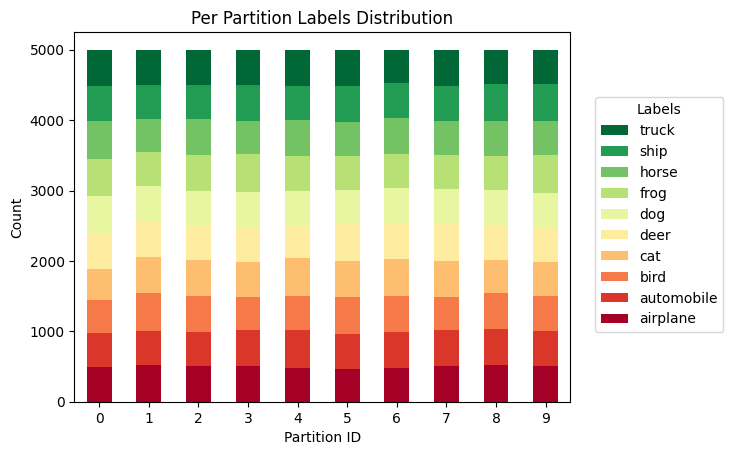

In [7]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

# Dirishlet Dataset Partitioning

In [8]:
fds = FederatedDataset(
    dataset="cifar10",
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=10,
            partition_by="label",
            alpha=0.3,
            seed=42,
            min_partition_size=0,
        ),
    },
)

partitioner = fds.partitioners["train"]

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

The alpha controls the symmetrical distribution, a higher value such as alpha=10 would mean more symmetrical and evenly distributed labels across partitions, while a low value such as alpha=0.1 would mean more unevenly distributed partitions

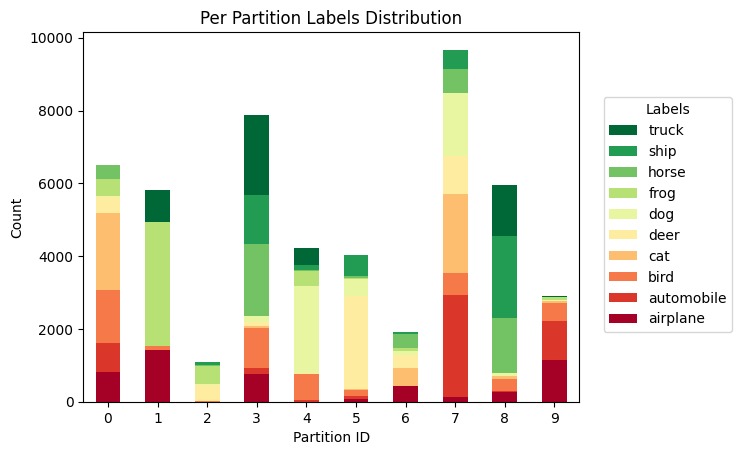

In [9]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

# Label Based Dataset Partitioning

In [10]:
partitioner = PathologicalPartitioner(
    num_partitions=10, partition_by="label", num_classes_per_partition=2
)

# Create the federated dataset passing the partitioner
fds = FederatedDataset(
    dataset="uoft-cs/cifar10", partitioners={"train": partitioner}
)

# Load the first partition
partition_pathological = fds.load_partition(partition_id=0)
partition_pathological

/usr/local/lib/python3.10/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 2501
})

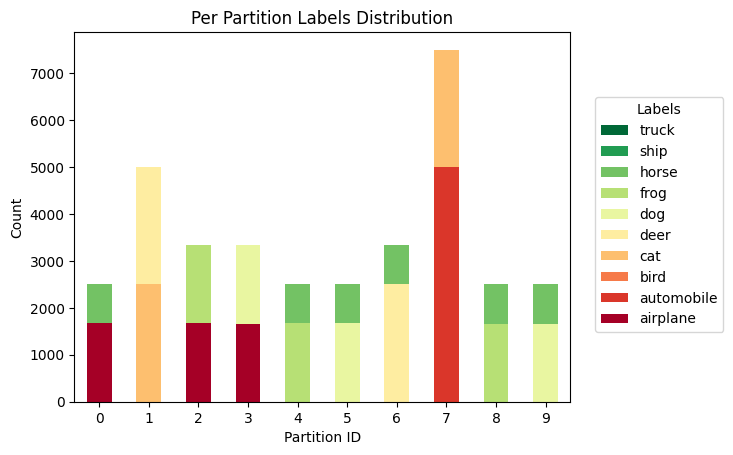

In [11]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

# DataHandling Function

In [51]:
# User will enter dataset name, partitioner (it can be based on label, or skewness or by default IID partitioning),

def dataset_initialization(dataset_name="uoft-cs/cifar10", num_partitions=1, num_classes_per_partition=None, alpha=None, visualize=False):
    if num_classes_per_partition is not None:
        partitioner = PathologicalPartitioner(num_partitions=num_partitions, partition_by="label", num_classes_per_partition=num_classes_per_partition)
    elif alpha is not None:
        partitioner = DirichletPartitioner(num_partitions=num_partitions, partition_by="label", alpha=alpha, seed=42, min_partition_size=0)
    else:
        partitioner = IidPartitioner(num_partitions=num_partitions)

    fds = FederatedDataset(
        dataset= dataset_name, partitioners={"train": partitioner}
        )

    partitioner = fds.partitioners["train"]

    if visualize:
      fig, ax, df = plot_label_distributions(
        partitioner,
        label_name="label",
        plot_type="bar",
        size_unit="absolute",
        partition_id_axis="x",
        legend=True,
        verbose_labels=True,
        title="Per Partition Labels Distribution",
      )

    return fds, partitioner

In [58]:
def get_partition_params():
    """Prompt user for dataset partitioning parameters."""
    dataset_name = input("Enter dataset name: ").strip()
    num_partitions = int(input("Enter the number of partitions (positive integer): "))
    choice = input("Partition by 'label' or 'skewness' or 'none' : ").strip().lower()
    params = {"dataset_name": dataset_name, "num_partitions": num_partitions, "num_classes_per_partition":None, "alpha":None}
    if choice == "label":
        params["num_classes_per_partition"] = int(input("Enter number of classes per partition (positive integer): "))
    elif choice == "skewness":
        params["alpha"] = float(input("Enter alpha value (positive float): "))
    elif choice == "none":
        pass
    else:
        raise ValueError("Invalid choice! Must be 'label' or 'skewness'.")
    return params

Enter dataset name: uoft-cs/cifar10
Enter the number of partitions (positive integer): 10
Partition by 'label' or 'skewness': label
Enter number of classes per partition (positive integer): 3


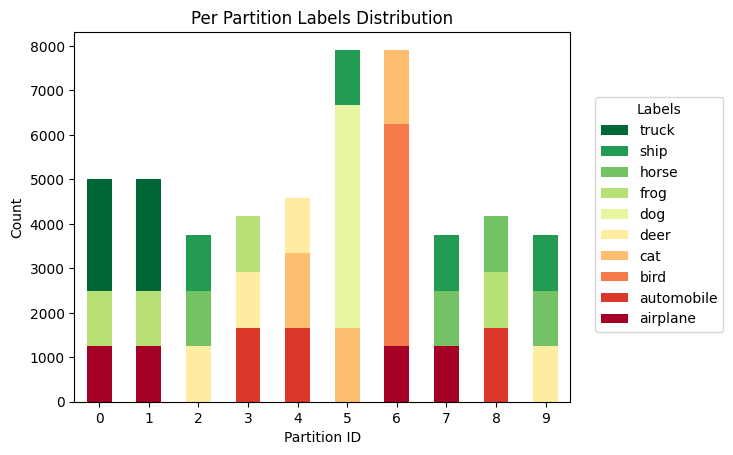

In [61]:
params = get_partition_params()
dataset=dataset_initialization(dataset_name=params["dataset_name"], num_partitions=params["num_partitions"], num_classes_per_partition=params["num_classes_per_partition"], alpha=params["alpha"], visualize=True)